In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_1d_slice, plot_timeseries
from superfv.initial_conditions import decaying_isotropic_turbulence

In [2]:
def compute_velocity_rms(sim):
    idx = sim.variable_index_map
    xp = sim.xp

    u = sim.arrays["u"]
    w = sim.primitives_from_conservatives(u)

    v = xp.sqrt(xp.mean(xp.sum(xp.square(w[idx("v")]), axis=0))).item()

    return v


def compute_turbulence_crossing_time(sim):
    mesh = sim.mesh

    Lx = mesh.xlim[1] - mesh.xlim[0]
    Ly = mesh.ylim[1] - mesh.ylim[0]
    Lz = mesh.zlim[1] - mesh.zlim[0]
    L = max(Lx, Ly, Lz)

    sigma = compute_velocity_rms(sim)

    return L / sigma


def compute_reference_dt(sim):
    mesh = sim.mesh

    h = min(mesh.hx, mesh.hy, mesh.hz)
    sigma = compute_velocity_rms(sim)

    return h / (3 * sigma)

In [3]:
base_path = "../out/isotropic-decaying-turbulence/"

N = 100
M_max = 50
seed = 1
slope = -5 / 3
dt_min_rel = 1e-4

common = dict(PAD={"rho": (0, None)}, SED=False)
apriori = dict(ZS=True, lazy_primitives="adaptive", **common)
aposteriori = dict(
    MOOD=True,
    lazy_primitives="full",
    MUSCL_limiter="minmod",
    limiting_vars=("rho", "vx", "vy"),
    **common,
)

configs = {
    "p0": dict(p=0),
    "MUSCL-Hancock": dict(p=1, MUSCL=True, MUSCL_limiter="moncen", **common),
    "ZS3": dict(p=3, GL=True, **apriori),
    "ZS7": dict(p=7, GL=True, **apriori),
    "MM3-3": dict(p=3, cascade="muscl1", max_MOOD_iters=3, **aposteriori),
    "MM7-3": dict(p=7, cascade="muscl1", max_MOOD_iters=3, **aposteriori),
}

In [ ]:
# Run simulations
sims = {}
for name, config in configs.items():
    print(f"- - - Starting simulation: {name}, seed={seed}, M_max={M_max} - - -")

    sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"

    # dummy sim used purely for computing T and dt_ref
    dummy_sim = EulerSolver(
        ic=partial(
            decaying_isotropic_turbulence,
            seed=seed,
            M=M_max,
            slope=slope,
            solenoidal=False,
        ),
        isothermal=True,
        nx=N,
        **config,
    )

    t_cross = compute_turbulence_crossing_time(dummy_sim)
    dt_ref = compute_reference_dt(dummy_sim)
    print(f"\tTurbulent crossing time = {t_cross:.4f}, dt_ref = {dt_ref:.2e}")

    sim = EulerSolver(
        ic=partial(
            decaying_isotropic_turbulence,
            seed=seed,
            M=M_max,
            slope=slope,
            solenoidal=False,
        ),
        isothermal=True,
        nx=N,
        dt_min=dt_min_rel * dt_ref,
        **config,
    )

    try:
        sim.run(
            [t.item() for t in np.linspace(0, t_cross, 4)[1:]],
            allow_overshoot=True,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            log_freq=1000,
            path=sim_path,
        )
        sim.write_timings()

        sims[name] = sim

    except FileExistsError:
        print(
            f"\nSimulation already completed and written to path {sim_path}, skipping.\n"
        )
        continue

    except Exception as e:

        if name in ("p0", "MUSCL-Hancock", "ZS3", "ZS7"):
            raise RuntimeError(f"Simulation {name} failed unexpectedly.") from e

        print(f"\nFailed: {e}\n")

        # write error
        with open(f"{sim_path}error.txt", "w") as f:
            f.write(str(e))

        continue

- - - Starting simulation: p0, seed=1, M_max=50 - - -
	Turbulent crossing time = 0.0400, dt_ref = 6.67e-05
Step #171 @ t=4.03e-02 | dt=6.30e-04 | min(rho)=6.68e-13, min(P)=6.68e-13 | E_cons=1.46e-11 | (ran in 0.08s)
- - - Starting simulation: MUSCL-Hancock, seed=1, M_max=50 - - -
	Turbulent crossing time = 0.0400, dt_ref = 6.67e-05
Step #177 @ t=4.02e-02 | dt=6.04e-04 | min(rho)=2.04e-03, min(P)=2.04e-03 | E_cons=1.46e-11 | (ran in 0.10s)
- - - Starting simulation: ZS3, seed=1, M_max=50 - - -
	Turbulent crossing time = 0.0400, dt_ref = 6.67e-05
Step #195 @ t=4.04e-02 | dt=6.48e-04 | min(rho)=5.51e-15, min(P)=5.51e-15 | E_cons=2.91e-11 | (ran in 0.85s)
- - - Starting simulation: ZS7, seed=1, M_max=50 - - -
	Turbulent crossing time = 0.0400, dt_ref = 6.67e-05
Step #236 @ t=4.02e-02 | dt=5.55e-04 | min(rho)=-4.18e-17, min(P)=-4.18e-17 | E_cons=2.91e-11 | (ran in 1.13s)
- - - Starting simulation: MM3-3, seed=1, M_max=50 - - -
	Turbulent crossing time = 0.0400, dt_ref = 6.67e-05
Step #172 @

/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.013352597284700523 not exactly matched in mesh; using nearest: 0.0133395
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.013352597284700523 not exactly matched in mesh; using nearest: 0.0133395
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.013352597284700523 not exactly matched in mesh; using nearest: 0.0133757
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.013352597284700523 not exactly matched in mesh; using nearest: 0.0133757
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.013352597284700523 not exactly matched in mesh; using nearest: 0.0133544
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visua

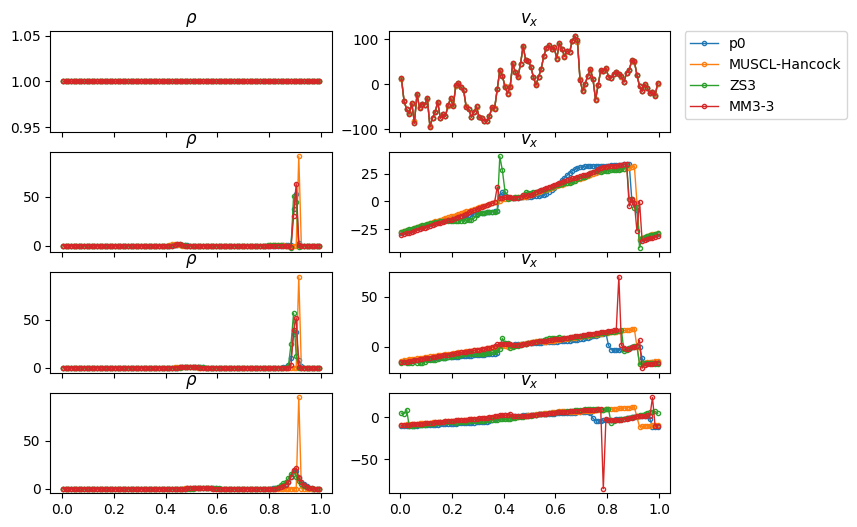

In [5]:
sim0 = sims["p0"]

fig, axs = plt.subplots(
    len(sim0.snapshots.time_values),
    2,
    sharex=True,
    figsize=(8, 12 * len(sim0.snapshots.time_values) / 8),
)

style0 = dict(color="k", linestyle="--", linewidth=1)
style1 = dict(linewidth=1, markersize=3, marker="o", mfc="none")

for i, tplot in enumerate(sim0.snapshots.time_values):
    for name in ["p0", "MUSCL-Hancock", "ZS3", "MM3-3"]:
        axs[i, 0].set_title(f"t={tplot:.2f}")
        axs[i, 1].set_title(f"t={tplot:.2f}")
        axs[i, 0].set_title(r"$\rho$")
        axs[i, 1].set_title(r"$v_x$")

        sim = sims[name]

        plot_1d_slice(sim, axs[i, 0], "rho", t=tplot, label=name, **style1)
        plot_1d_slice(sim, axs[i, 1], "vx", t=tplot, label=name, **style1)

axs[0, 1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

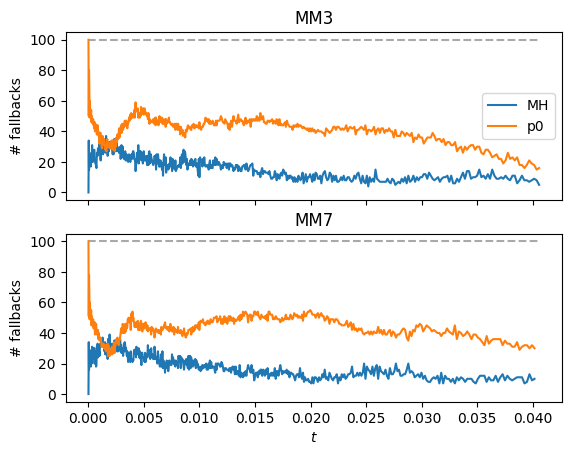

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].set_title("MM3")
axs[1].set_title("MM7")
axs[0].set_ylabel("# fallbacks")
axs[1].set_ylabel("# fallbacks")
axs[1].set_xlabel(r"$t$")

sim1 = sims["MM3-3"]
sim2 = sims["MM7-3"]

for i in range(2):
    axs[i].plot(
        [0, sim1.minisnapshots["t"][-1]], [N] * 2, color="darkgrey", linestyle="--"
    )

plot_timeseries(sim1, axs[0], "nfine_cascade_idx1", label="MH")
plot_timeseries(sim1, axs[0], "nfine_cascade_idx2", label="p0")

plot_timeseries(sim2, axs[1], "nfine_cascade_idx1", label="MH")
plot_timeseries(sim2, axs[1], "nfine_cascade_idx2", label="p0")

axs[0].legend()